In [2]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.hux import HUX
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from joblib import Parallel, delayed

from ucimlrepo import fetch_ucirepo 
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Overall function definitions

In [3]:
class InstanceSelectionProblem(Problem):
	n_neighbors = 5
	def __init__(self, X_train, y_train, X_val, y_val):
		
		self.X_train = X_train
		self.y_train = y_train

		self.X_val = X_val
		self.y_val = y_val

		self.training_data = X_train
		self.n_instances = X_train.shape[0]
		
		super().__init__(
			n_var=self.n_instances,
			n_obj=2,               
			n_constr=0,            
			xl=0,                  
			xu=1,                  
			type_var=np.bool_,     
		)

	def _evaluate(self, x, out, *args, **kwargs):
		# Calculate number of examples in each instance
		f1 = np.sum(x, axis=1)

		# Calculate inverse accuracy
		f2 = Parallel(n_jobs=-1)(delayed(self.train_model)(instance) for instance in x)

		out["F"] = np.column_stack([f1, f2])

	def train_model(self, instance):
		x_train_filtered, y_train_filtered = self.X_train[instance], self.y_train[instance]
		
		num_included_instances = x_train_filtered.shape[0]

		if num_included_instances >= InstanceSelectionProblem.n_neighbors:
			optimization_knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem.n_neighbors)
			optimization_knn.fit(x_train_filtered, y_train_filtered)

			y_pred = optimization_knn.predict(self.X_val)
			acc = accuracy_score(self.y_val, y_pred)
			return 1-acc
		else:
			return 1


def split_and_scale_datasets(X, y, split_1=0.5, split_2=0.5, random_state=42, scale=True):
	X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=split_1, random_state=random_state, stratify=y)
	X_val, X_test, y_val, y_test =  train_test_split(X_temp, y_temp, test_size=split_2, random_state=random_state, stratify=y_temp)

	if scale:
		scaler = StandardScaler()
		X_train = scaler.fit_transform(X_train)
		X_test = scaler.transform(X_test)
		X_val = scaler.transform(X_val)

	return X_train, X_val, X_test, y_train, y_val, y_test

def set_summary(dataset, set_name):

	if "x" in set_name.lower():
		num_examples = dataset.shape[0]
		num_features = dataset.shape[1]

		print(f"\nSummary for set {set_name}")
		print(f"\t- Num examples: {num_examples}")
		print(f"\t- Num features: {num_features}")

	if "y" in set_name:
		counts = pd.DataFrame(dataset).value_counts()
		class_0_count = counts[0]
		class_1_count = counts[1]

		majority_class = max(class_0_count, class_1_count)
		minority_class = min(class_0_count, class_1_count)

		majority_class_name = 0 if majority_class == class_0_count else class_1_count

		print(f"\nSummary for set {set_name}")
		print(f"\t- Number of examples in class 0: {class_0_count}")
		print(f"\t- Number of examples in class 1: {class_1_count}")
		print(f"\t- Total number of examples: {class_0_count + class_1_count}")
		print(f"\t- Imbalance ratio: {round(majority_class/minority_class, 4)} (Majority class is {majority_class_name})")		

def generate_PCA(X, y, plot_title):
	pca = PCA(n_components=2)
	X_pca = pca.fit_transform(X)
	plt.figure(figsize=(8, 6))
	plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', edgecolor='k')
	plt.title(plot_title)
	plt.xlabel('Principal Component 1')
	plt.ylabel('Principal Component 2')
	return X_pca, pca


# Generic Cancer KNN dataset - Kaggle

## Split sets into train, validation, and test (equalize distributions)

https://www.kaggle.com/datasets/gkalpolukcu/knn-algorithm-dataset 


Summary for set X
	- Num examples: 569
	- Num features: 30

Summary for set y
	- Number of examples in class 0: 357
	- Number of examples in class 1: 212
	- Total number of examples: 569
	- Imbalance ratio: 1.684 (Majority class is 0)



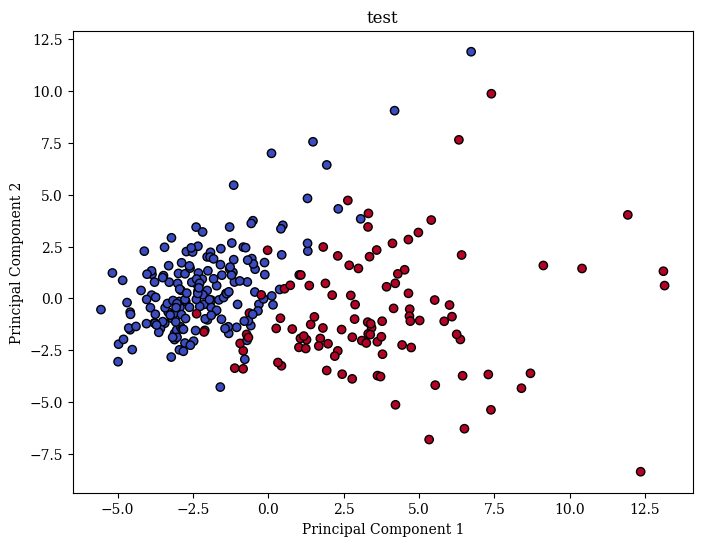

In [61]:
df = pd.read_csv("KNNAlgorithmDataset.csv")
df = df.drop(columns="Unnamed: 32").drop(columns="id")
X = df.drop(columns='diagnosis') 
y = df['diagnosis'] 

set_summary(X, 'X')
set_summary(y, 'y')
print("")

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_val, X_test, y_train, y_val, y_test = split_and_scale_datasets(X, y_encoded)
generate_PCA(X_train, y_train, "test")
plt.show()

## Establish baseline test accuracy with entire train set

In [62]:
baseline_knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem.n_neighbors)
baseline_knn.fit(X_train, y_train)
y_pred = baseline_knn.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))

Test accuracy: 0.972027972027972


## Run Genetic Algorithm (NGA-II)

In [63]:
problem = InstanceSelectionProblem(X_train, y_train, X_val, y_val)
algorithm = NSGA2(pop_size=100, sampling=BinaryRandomSampling(), crossover=HUX(), mutation=BitflipMutation(), eliminate_duplicates=True)
res = minimize(problem, algorithm, ('n_gen', 100), verbose=False, seed=42)

## Show first rank pareto front

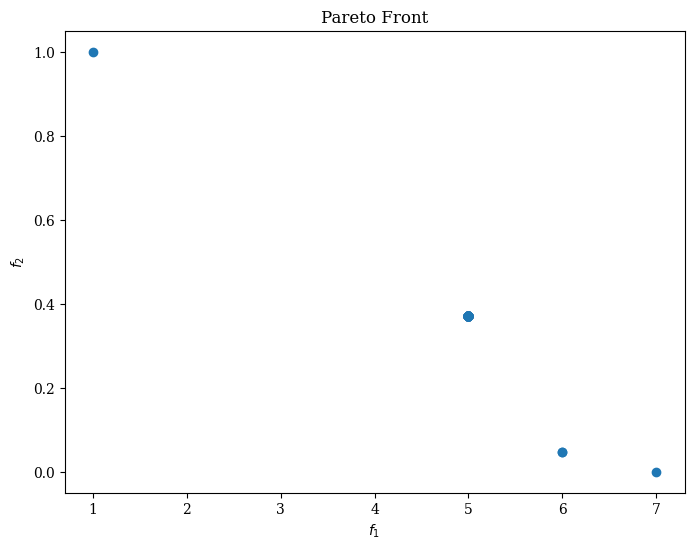

In [64]:
plot = Scatter(title="Pareto Front")
plot.add(res.F, label="Pareto-optimal solutions")
plot.show()
best_solution = res.X[0]

In [65]:
x_train_filtered, y_train_filtered = X_train[best_solution], y_train[best_solution]
final_test_knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem.n_neighbors)
final_test_knn.fit(x_train_filtered, y_train_filtered)
y_pred = final_test_knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)

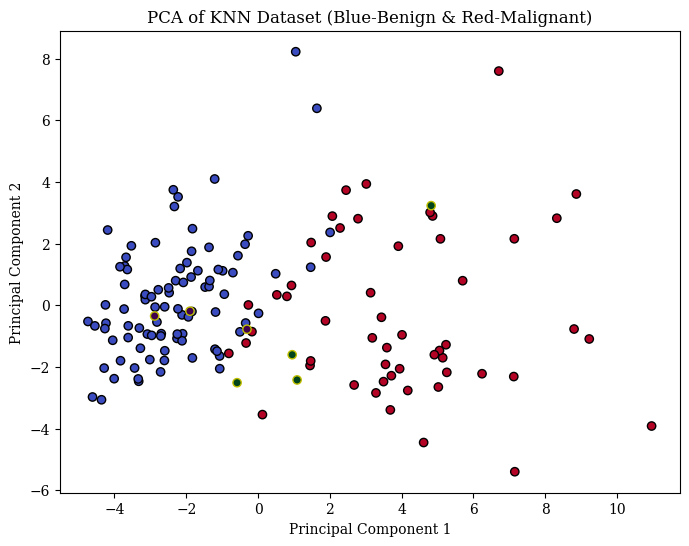

In [66]:
selected_indices_idx = []
for row in x_train_filtered:
	selected_indices_idx.append(np.where((row == X_train).all(axis=1))[0][0])
x_train_selections = X_train[selected_indices_idx]

X_pca, pca = generate_PCA(X_test, y_test, 'PCA of KNN Dataset (Blue-Benign & Red-Malignant)')
X_train_pca = pca.transform(x_train_filtered)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train_filtered, cmap='PRGn', linewidth=1, edgecolors='y')
plt.show()

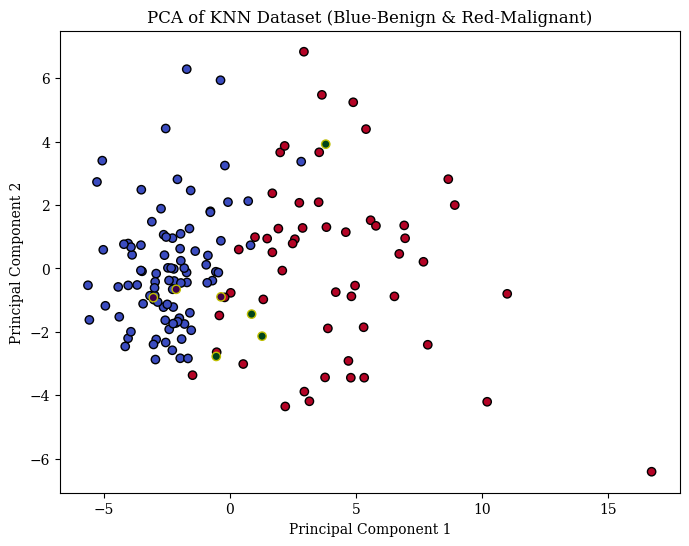

In [67]:

X_pca, pca = generate_PCA(X_val, y_val, 'PCA of KNN Dataset (Blue-Benign & Red-Malignant)')
X_train_pca = pca.transform(x_train_filtered)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train_filtered, cmap='PRGn', linewidth=1, edgecolors='y')
plt.show()

# Census Income Dataset - UCI (Not working)

In [3]:
# fetch dataset 
census_income_kdd = fetch_ucirepo(id=117) 
  
# data (as pandas dataframes) 
X = census_income_kdd.data.features 
y = census_income_kdd.data.targets

KeyboardInterrupt: 

In [15]:
l1 = "AAGE, ACLSWKR, ADTIND, ADTOCC, AGI, AHGA, AHRSPAY, AHSCOL, AMARITL, AMJIND, AMJOCC, ARACE, AREORGN, ASEX, AUNMEM, AUNTYPE, AWKSTAT, CAPGAIN, CAPLOSS, DIVVAL, FEDTAX, FILESTAT, GRINREG, GRINST, HHDFMX, HHDREL, MARSUPWT, MIGMTR1, MIGMTR3, MIGMTR4, MIGSAME, MIGSUN, PARENT, PEARNVAL, PEFNTVTY, PEMNTVTY, PENATVTY, PRCITSHP, PTOTVAL, SEOTR, TAXINC, VETQVA, VETYN, WKSWORK, targets"
l2 = "73, Not in universe, 0, 0, High school graduate, 0, Not in universe, Widowed, Not in universe or children, Not in universe, White, All other, Female, Not in universe, Not in universe, Not in labor force, 0, 0, 0, Nonfiler, Not in universe, Not in universe, Other Rel 18+ ever marr not in subfamily, Other relative of householder, 1700.09, ?, ?, ?, Not in universe under 1 year old, ?, 0, Not in universe, United-States, United-States, United-States, Native- Born in the United States, 0, Not in universe, 2, 0, 95, - 50000."

s1 = l1.split(",")
s2 = l2.split(",")
print(len(s1), len(s2))

45 42


In [11]:
df = pd.read_csv("Datasets/census_income/census-income.csv", delimiter=', ')
df.dropna(inplace=True)

X = df.drop(columns='targets')
y = df['targets']

ordinal_features = ["AHGA", "AMARITL"]

nominal_features = ["ACLSWKR", "AMJIND", "AMJOCC", "ARACE", "AREORGN", "ASEX", 
                    "AUNMEM", "AUNTYPE", "AWKSTAT", "FILESTAT", "GRINREG", 
                    "GRINST", "HHDFMX", "HHDREL", "MIGMTR1", "MIGMTR3", "MIGMTR4", 
                    "MIGSAME", "MIGSUN", "PARENT", "PEFNTVTY", "PEMNTVTY", "PENATVTY", 
                    "PRCITSHP", "SEOTR", "VETQVA", "VETYN"]

numerical_features = ["AAGE", "CAPGAIN", "GAPLOSS", "DIVVAL", "AHRSPAY", "WKSWORK", "year"]

ordinal_encoder = OrdinalEncoder()
scaler = StandardScaler()
print(X.shape)
X_encoded = X
X_encoded[ordinal_features] = ordinal_encoder.fit_transform(df[ordinal_features])
X_encoded = pd.get_dummies(df, columns=nominal_features, drop_first=True)
X_encoded[numerical_features] = scaler.fit_transform(df[numerical_features])

C:\Users\RjKim\AppData\Local\Temp\ipykernel_3960\610754659.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("Datasets/census_income/census-income.csv", delimiter=', ')


(0, 44)


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [50]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(temp_Y)
X_train, X_val, X_test, y_train, y_val, y_test = split_and_scale_datasets(X_encoded, y_encoded, scale=False)

set_summary(X_train, "X_train")
set_summary(y_train, "y_train")


Summary for set X_train
	- Num examples: 47565
	- Num features: 341

Summary for set y_train
	- Number of examples in class 0: 2739
	- Number of examples in class 1: 44826
	- Total number of examples: 47565
	- Imbalance ratio: 16.3658 (Majority class is 44826)


In [51]:
baseline_knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem.n_neighbors)
baseline_knn.fit(X_train, y_train)
y_pred = baseline_knn.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))

ValueError: could not convert string to float: ' Not in universe'

In [ ]:
problem = InstanceSelectionProblem(X_train, y_train, X_val, y_val)
algorithm = NSGA2(pop_size=100, sampling=BinaryRandomSampling(), crossover=HUX(), mutation=BitflipMutation(), eliminate_duplicates=True)
res = minimize(problem, algorithm, ('n_gen', 100), verbose=False, seed=42)

In [ ]:
plot = Scatter(title="Pareto Front")
plot.add(res.F, label="Pareto-optimal solutions")
plot.show()
best_solution = res.X[0]

In [ ]:
x_train_filtered, y_train_filtered = X_train[best_solution], y_train[best_solution]
final_test_knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem.n_neighbors)
final_test_knn.fit(x_train_filtered, y_train_filtered)
y_pred = final_test_knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy using best instance {acc}")

In [ ]:
selected_indices_idx = []
for row in x_train_filtered:
	selected_indices_idx.append(np.where((row == X_train).all(axis=1))[0][0])
x_train_selections = X_train[selected_indices_idx]

X_pca, pca = generate_PCA(X_test, y_test, 'PCA of KNN Dataset (Blue-Benign & Red-Malignant)')
X_train_pca = pca.transform(x_train_filtered)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train_filtered, cmap='PRGn', linewidth=1, edgecolors='y')
plt.show()

# Glass1 - KEEL (Working)

C:\Users\RjKim\AppData\Local\Temp\ipykernel_20676\1302753350.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("Datasets/glass1/glass1.csv", delimiter=', ')


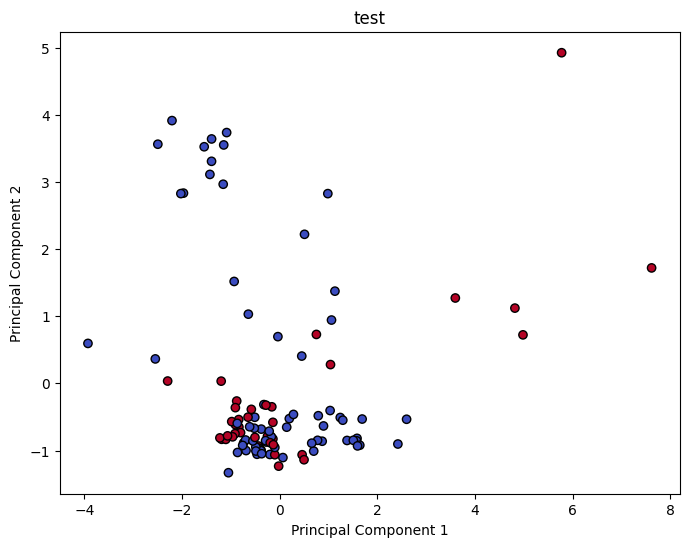

Test accuracy: 0.7407407407407407


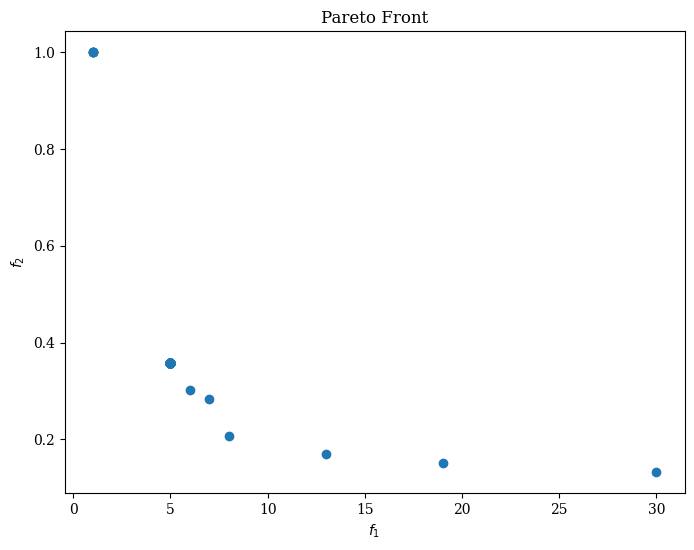

In [4]:
# Load the dataset
df = pd.read_csv("Datasets/glass1/glass1.csv", delimiter=', ')
X = df.drop(columns='Class')
y = df['Class']

# Generate train, validation, and test sets
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_val, X_test, y_train, y_val, y_test = split_and_scale_datasets(X, y_encoded)

# Generate PCA for training set
# generate_PCA(X_train, y_train, "test")
# plt.show()

# Determine baseline accuracy of classifier on all examples
baseline_knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem.n_neighbors)
baseline_knn.fit(X_train, y_train)
y_pred = baseline_knn.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))

# Run optimization on training set, using validation metrics
problem = InstanceSelectionProblem(X_train, y_train, X_val, y_val)
algorithm = NSGA2(pop_size=100, sampling=BinaryRandomSampling(), crossover=HUX(), mutation=BitflipMutation(), eliminate_duplicates=True)
res = minimize(problem, algorithm, ('n_gen', 100), verbose=False, seed=42)

# Display first pareto front
plot = Scatter(title="Pareto Front")
plot.add(res.F, label="Pareto-optimal solutions")
plot.show()
best_solution = res.X[0]

# Calculate the test accuracy using the best solution result from GA optimization
x_train_filtered, y_train_filtered = X_train[best_solution], y_train[best_solution]
final_test_knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem.n_neighbors)
final_test_knn.fit(x_train_filtered, y_train_filtered)
y_pred = final_test_knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy using best instance {acc}")



# Generate PCA of the test set, and highlight training set instance which yields best performance
selected_indices_idx = []
for row in x_train_filtered:
	selected_indices_idx.append(np.where((row == X_train).all(axis=1))[0][0])
x_train_selections = X_train[selected_indices_idx]

X_pca, pca = generate_PCA(X_test, y_test, 'PCA of test set with best instances overlayed')
X_train_pca = pca.transform(x_train_filtered)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train_filtered, cmap='PRGn', linewidth=1, edgecolors='r')
plt.show()

# Pima - KEEL (Working)


Summary for set X
	- Num examples: 768
	- Num features: 8

Summary for set y
	- Number of examples in class 0: 500
	- Number of examples in class 1: 268
	- Total number of examples: 768
	- Imbalance ratio: 1.8657 (Majority class is 0)



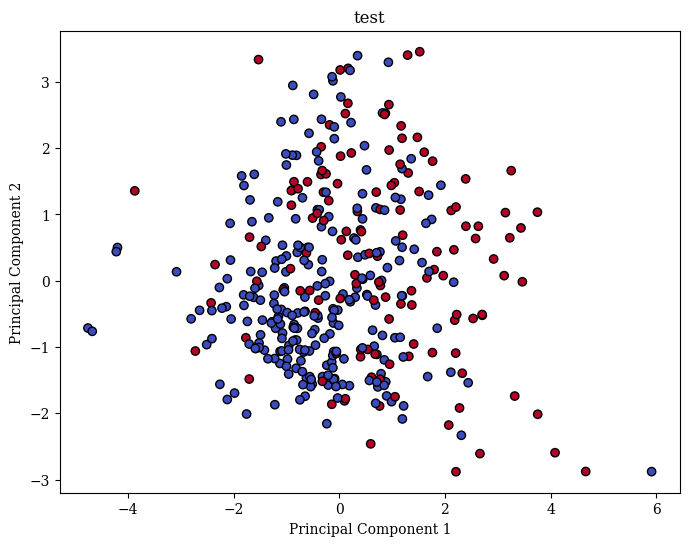

In [76]:
df = pd.read_csv("Datasets/pima/pima.csv", delimiter=',')

X = df.drop(columns='Diabetic')
y = df['Diabetic']

set_summary(X, 'X')
set_summary(y, 'y')
print("")

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_val, X_test, y_train, y_val, y_test = split_and_scale_datasets(X, y_encoded)
generate_PCA(X_train, y_train, "test")
plt.show()

In [77]:
baseline_knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem.n_neighbors)
baseline_knn.fit(X_train, y_train)
y_pred = baseline_knn.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))

Test accuracy: 0.7135416666666666


In [78]:
problem = InstanceSelectionProblem(X_train, y_train, X_val, y_val)
algorithm = NSGA2(pop_size=100, sampling=BinaryRandomSampling(), crossover=HUX(), mutation=BitflipMutation(), eliminate_duplicates=True)
res = minimize(problem, algorithm, ('n_gen', 100), verbose=False, seed=42)

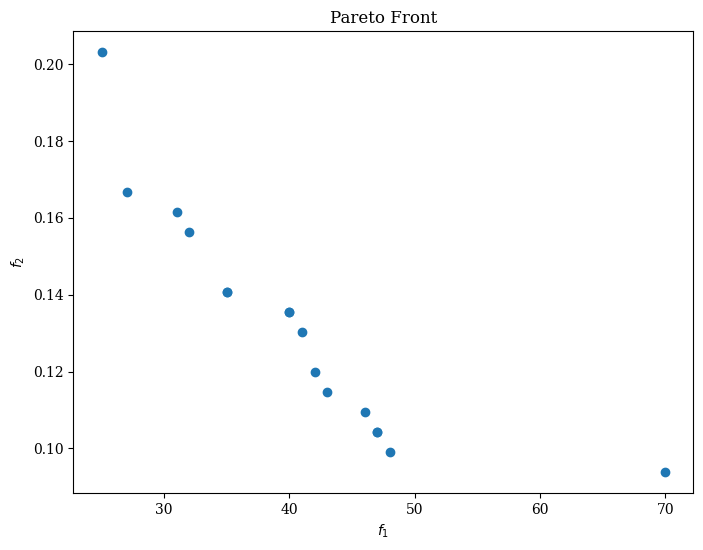

In [79]:
plot = Scatter(title="Pareto Front")
plot.add(res.F, label="Pareto-optimal solutions")
plot.show()
best_solution = res.X[0]

In [81]:
final_test_knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem.n_neighbors)
final_test_knn.fit(X_train, y_train)
y_pred = final_test_knn.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"Val accuracy using best instance {acc}")

Val accuracy using best instance 0.7291666666666666


In [84]:
final_test_knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem.n_neighbors)
final_test_knn.fit(x_train_filtered, y_train_filtered)
y_pred = final_test_knn.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"Val accuracy using best instance {acc}")

Val accuracy using best instance 0.8697916666666666


In [83]:
x_train_filtered, y_train_filtered = X_train[best_solution], y_train[best_solution]
final_test_knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem.n_neighbors)
final_test_knn.fit(x_train_filtered, y_train_filtered)
y_pred = final_test_knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy using best instance {acc}")

Test accuracy using best instance 0.6822916666666666


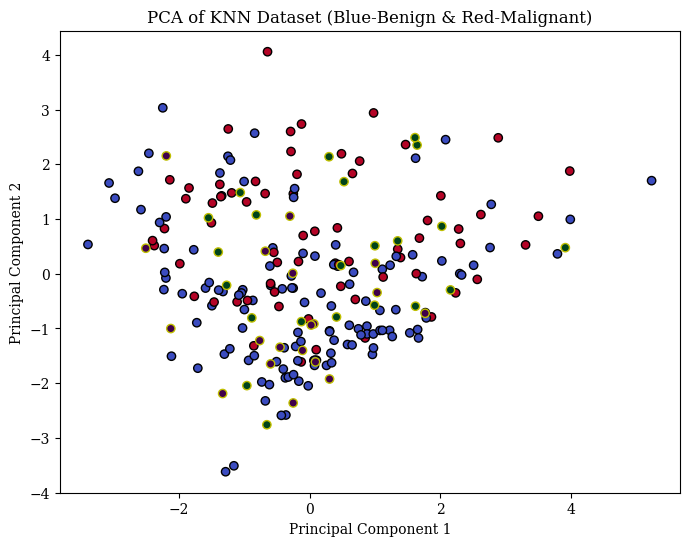

In [132]:
selected_indices_idx = []
for row in x_train_filtered:
	selected_indices_idx.append(np.where((row == X_train).all(axis=1))[0][0])
x_train_selections = X_train[selected_indices_idx]

X_pca, pca = generate_PCA(X_test, y_test, 'PCA of KNN Dataset (Blue-Benign & Red-Malignant)')
X_train_pca = pca.transform(x_train_filtered)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train_filtered, cmap='PRGn', linewidth=1, edgecolors='y')
plt.show()

# Wisconsin - KEEL (Not Working)

In [150]:
wisconsin_path = "Datasets/wisconsin/wisconsin.csv"
df = pd.read_csv(wisconsin_path, delimiter=', ')

X = df.drop(columns='Benign')
y = df['Benign']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

set_summary(y_encoded, 'y_encoded')
print(y_encoded.shape)
print(X.shape)
X_train, X_val, X_test, y_train, y_val, y_test = split_and_scale_datasets(X, y_encoded, split_1=0.8)
# generate_PCA(X_train, y_train, "test")
# plt.show()


Summary for set y_encoded
	- Number of examples in class 0: 443
	- Number of examples in class 1: 239
	- Total number of examples: 682
	- Imbalance ratio: 1.8536 (Majority class is 0)
(683,)
(683, 9)


C:\Users\RjKim\AppData\Local\Temp\ipykernel_3048\3902750791.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(wisconsin_path, delimiter=', ')


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.